<!--<badge>--><a href="https://colab.research.google.com/github/softmatterlab/DeepTrack-2.0/blob/develop/examples/paper-examples/1-MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

In [1]:
%matplotlib inline

!pip install deeptrack

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import itertools
import deeptrack as dt

c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.7.0 and strictly below 2.10.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [3]:
IMAGE_SIZE = 32
RADIUS_MIN = 5
RADIUS_MAX = 10

In [4]:
# Define the object 
disk = dt.Ellipse(
    position=(IMAGE_SIZE / 2, IMAGE_SIZE / 2),
    radius=lambda: np.random.uniform(RADIUS_MIN, RADIUS_MAX) * dt.units.px,
)

In [5]:
# Define the microscope
optics = dt.Fluorescence(
    magnification=5,
    NA=0.9,
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
)

In [6]:
# Define noise
poisson_noise = dt.Poisson(snr=5)

In [7]:
# Define normalization
normalization = dt.NormalizeMinMax(0, 1)

In [8]:
# Define pipeline
simulation_pipeline = optics(disk) >> poisson_noise >> normalization

<AxesSubplot:>

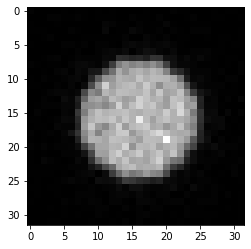

In [9]:
simulation_pipeline.update().plot(cmap="gray")

In [10]:
# Define label. Normalize to [0, 1] to make it easier for the network to learn
label_pipeline = disk.radius

In [11]:
# Combine pipeline and label
dataset = simulation_pipeline & label_pipeline

Label:  Image(array(5.10665067))


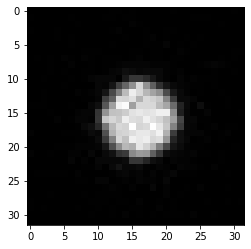

In [12]:
# show examples
dataset.update()
image, label = dataset()

print("Label: ", label)
plt.imshow(image, cmap="gray")
plt.show()

In [13]:
# Create validation set
validation_set_size = 256
validation_data, validation_labels = zip(*[dataset.update()() for _ in range(validation_set_size)])

validation_data = np.array(validation_data)
validation_labels = np.array(validation_labels)[..., np.newaxis]

print("Validation data shape: ", validation_data.shape)
print("Validation labels shape: ", validation_labels.shape)

Validation data shape:  (256, 32, 32, 1)
Validation labels shape:  (256, 1)


## 3. Defining the network

The network used is a fully connected neural network. Here we define the network architecture, loss function and the optimizer.

In [14]:
model = dt.models.FullyConnected(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1),
    dense_layers_dimensions=(500, 500, 500),
    number_of_outputs=1,
    output_activation="linear",
    loss="mae",
    metrics=["mse"],
    optimizer="rmsprop"
)

## 4. Training the network

Generating 1001 / 1000 samples before starting training
Epoch 1/200
31/31 [==============================] - 2s 16ms/step - loss: 2.1682 - mse: 9.4094 - val_loss: 0.4444 - val_mse: 0.2896
Epoch 2/200
31/31 [==============================] - 0s 10ms/step - loss: 1.1816 - mse: 2.1098 - val_loss: 0.8230 - val_mse: 0.8478
Epoch 3/200
31/31 [==============================] - 0s 10ms/step - loss: 1.0735 - mse: 1.6660 - val_loss: 0.2481 - val_mse: 0.1068
Epoch 4/200
31/31 [==============================] - 0s 9ms/step - loss: 0.9165 - mse: 1.2130 - val_loss: 1.1999 - val_mse: 1.5552
Epoch 5/200
31/31 [==============================] - 0s 9ms/step - loss: 0.9191 - mse: 1.1994 - val_loss: 0.8896 - val_mse: 0.9141
Epoch 6/200
31/31 [==============================] - 0s 10ms/step - loss: 0.8527 - mse: 0.9694 - val_loss: 0.9519 - val_mse: 0.9891
Epoch 7/200
31/31 [==============================] - 0s 9ms/step - loss: 0.8173 - mse: 0.8623 - val_loss: 0.6445 - val_mse: 0.5314
Epoch 8/200
31/31 [====

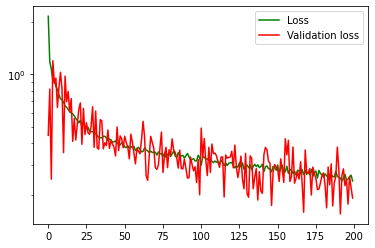

In [15]:

generator = dt.generators.ContinuousGenerator(
    dataset,
    batch_size=32,
    min_data_size=1000,
    max_data_size=1001,
)

with generator:
    h = model.fit(
        generator,
        validation_data=(
            validation_data,
            validation_labels
        ),
        epochs=200
    )

plt.plot(h.history["loss"], 'g')
plt.plot(h.history["val_loss"], 'r')
plt.legend(["Loss", "Validation loss"])
plt.yscale("log")
plt.show()


8/8 [==============================] - 0s 1ms/step


Text(0, 0.5, 'True scaled radius')

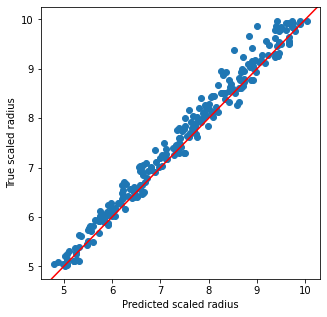

In [16]:
# Evaluate model
predictions = model.predict(np.array(validation_data))

plt.figure(figsize=(5, 5))

plt.scatter(predictions, np.array(validation_labels))
plt.axline((RADIUS_MIN, RADIUS_MIN), (RADIUS_MAX, RADIUS_MAX), color="red")
plt.xlabel("Predicted scaled radius")
plt.ylabel("True scaled radius")